# 03. Computer vision & convolutional neural networks in TensorFlow Exercises

1. **Spend 20-minutes reading and interacting with the CNN explainer website**

    1. What are the key terms? e.g. explain convolution in your own words, pooling in your own words

2. **Play around with the "understanding hyperparameters" section in the CNN explainer website for 10-minutes.**

    1. What is the kernel size?
    2. What is the stride?
    3. How could you adjust each of these in TensorFlow code?

3. **Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.**
4. **Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.**


## 1. Spend ~20-minutes reading and interacting with the CNN explainer website

### 1.1 What are the key terms? e.g. explain convolution in your own words, pooling in your own words

CNN is a neural network algorithm that identifies patterns in input data, especially images and text.

## 2. Play around with the "understanding hyperparameters" section in the CNN explainer website for 10-minutes.

### 2.1 What is the kernel size

Kernel size determines the dimensions of the filter used to scan for patterns in input data.

### 2.2 What is the stride

Stride specifies how much kernel moves between every "scan".

### 2.3 How could you adjust each of these in TensorFlow code?

Kernel size and stride can both be specified in convolutional layer of the model.

For example:
```python
tf.keras.layers.Conv2D(..., kernel_size=3, strides=(1,1), ...)

tf.keras.layers.Conv1D(..., kernel_size=3, strides=1, ...)
```

## 3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.

### 3.1 install cats and dogs dataset instead 

In [1]:
!rm -rf cats-and-dogs*
#!wget -q -O cats-and-dogs.zip https://www.kaggle.com/api/v1/datasets/download/samuelcortinhas/cats-and-dogs-image-classification
!wget -q -O cats-and-dogs.zip https://www.kaggle.com/api/v1/datasets/download/anthonytherrien/dog-vs-cat
!unzip -qq -d cats-and-dogs cats-and-dogs.zip
!rm -rf cats-and-dogs.zip

import os

for dirpath, dirnames, filenames in os.walk('cats-and-dogs'):
    print(f"The are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

The are 1 directories and 0 images in 'cats-and-dogs'
The are 2 directories and 0 images in 'cats-and-dogs/animals'
The are 0 directories and 500 images in 'cats-and-dogs/animals/cat'
The are 0 directories and 500 images in 'cats-and-dogs/animals/dog'


#### 3.1.1 Little setup

In [2]:
IMGSIZE=224
BATCHSIZE=32

### 3.2 Get class names

In [3]:
import pathlib
import numpy as np

data_dir = pathlib.Path("cats-and-dogs/animals")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['cat' 'dog']


### 3.3 Add functions to view images

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf

def view_random_image(target_dir, target_class):
    # Setup the target directory
    target_folder = target_dir+"/"+target_class
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")
    return img

# Create a function to import image and resize it to be able to used with our model
def load_and_prep_image(filename, img_shape=IMGSIZE):
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=(img_shape, img_shape))
    # Rescale the image
    img = img/255.
    return img

def pred_and_plot(model, filename, class_names=class_names):
    # Import the target image and preprocess
    img = load_and_prep_image(filename)
    # Make prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    print(pred, class_names)
    # Add in logic for multi-class
    if len(pred[0]) > 1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred))]
    # Plot the image and predicted calss
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    

['00120-200124430.png']
Image shape: (512, 512, 3)
['00650-3846168812.png']
Image shape: (512, 512, 3)


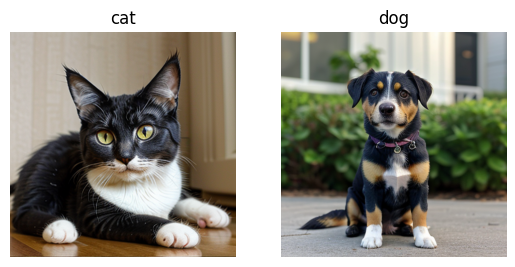

In [5]:
plt.figure()
plt.subplot(1,2,1)
img = view_random_image("cats-and-dogs/animals/", "cat")
plt.subplot(1,2,2)
img = view_random_image("cats-and-dogs/animals/", "dog")

### 3.4 Create datagenerator (add Preprocessing and data augmentation)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0,
    rotation_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.3,
    horizontal_flip=True
)

#test_data_generator = ImageDataGenerator(rescale=1./255)

### 3.5 Create train and test data

In [7]:
tf.random.set_seed(42)
train_data = train_data_generator.flow_from_directory(
    "cats-and-dogs/animals", 
    target_size=(IMGSIZE,IMGSIZE), 
    batch_size=BATCHSIZE, 
    class_mode="binary",
    subset='training',
    seed=42
)
test_data = train_data_generator.flow_from_directory(
    "cats-and-dogs/animals", 
    target_size=(IMGSIZE,IMGSIZE), 
    batch_size=BATCHSIZE, 
    class_mode="binary",
    subset='validation'
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3.6 Create, compile and fit the model

In [8]:
import tensorflow as tf

In [9]:
# Set random seed
tf.random.set_seed(42)

# Create model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(IMGSIZE, IMGSIZE, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
model_1_history = model_1.fit(
    train_data,
    epochs=10,
    batch_size=BATCHSIZE,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    verbose=1,
)
model_1.evaluate(test_data, batch_size=BATCHSIZE)

Epoch 1/10
25/25 [==============================] - 13s 446ms/step - loss: 0.7052 - accuracy: 0.5000 - val_loss: 0.6870 - val_accuracy: 0.5700
Epoch 2/10
25/25 [==============================] - 11s 448ms/step - loss: 0.6702 - accuracy: 0.6237 - val_loss: 0.6282 - val_accuracy: 0.6750
Epoch 3/10
25/25 [==============================] - 11s 451ms/step - loss: 0.6223 - accuracy: 0.6488 - val_loss: 0.5907 - val_accuracy: 0.6350
Epoch 4/10
25/25 [==============================] - 11s 450ms/step - loss: 0.6117 - accuracy: 0.6700 - val_loss: 0.5758 - val_accuracy: 0.6800
Epoch 5/10
25/25 [==============================] - 11s 450ms/step - loss: 0.6046 - accuracy: 0.6662 - val_loss: 0.5517 - val_accuracy: 0.7500
Epoch 6/10
25/25 [==============================] - 11s 444ms/step - loss: 0.6014 - accuracy: 0.6775 - val_loss: 0.5310 - val_accuracy: 0.7950
Epoch 7/10
25/25 [==============================] - 11s 447ms/step - loss: 0.5372 - accuracy: 0.7325 - val_loss: 0.4998 - val_accuracy: 0.7800

[0.5555629134178162, 0.6600000262260437]

1/1 [==============================] - 0s 127ms/step
[[0.44688383]] ['cat' 'dog']
1/1 [==============================] - 0s 14ms/step
[[0.62805057]] ['cat' 'dog']


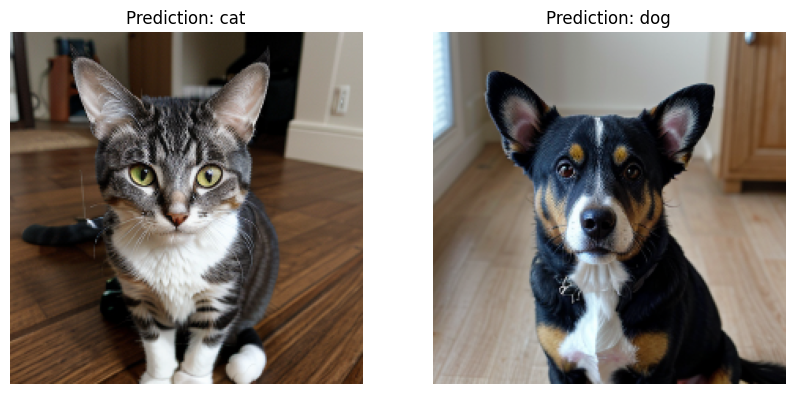

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
pred_and_plot(model_1, "cats-and-dogs/animals/cat/00000-4122619873.png")
plt.subplot(1,2,2)
pred_and_plot(model_1, "cats-and-dogs/animals/dog/00500-3846168662.png")

### 3.7 Plot loss curves

In [11]:
# Let's plot training and validation cuurves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for traiing and validation metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    plt.figure(figsize=(10,3))
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    # Plot accuracy    
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

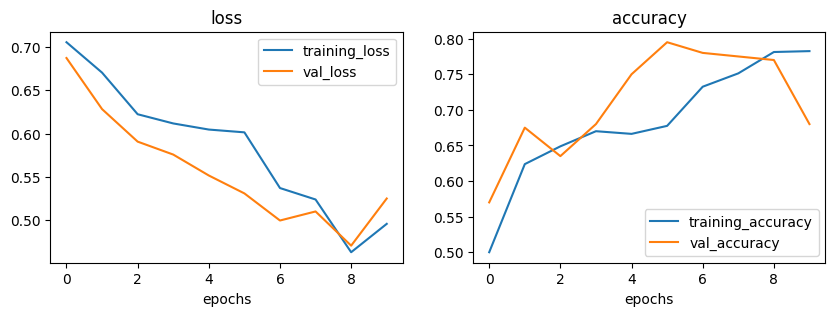

In [12]:
plot_loss_curves(model_1_history)

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## 4. Find an ideal learning rate for a simple convolutional neural network model on your dataset.

In [19]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [22]:
tf.random.set_seed(42)
model_2 =tf.keras.models.clone_model(model_1)
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_2_history = model_2.fit(
    train_data,
    epochs=100,
    batch_size=BATCHSIZE,
    steps_per_epoch=2,
    callbacks = [lr_scheduler],
    verbose=0,
)
model_2.evaluate(test_data, batch_size=BATCHSIZE)

7/7 [==============================] - 2s 310ms/step - loss: 1.0968 - accuracy: 0.5000


[1.0967942476272583, 0.5]

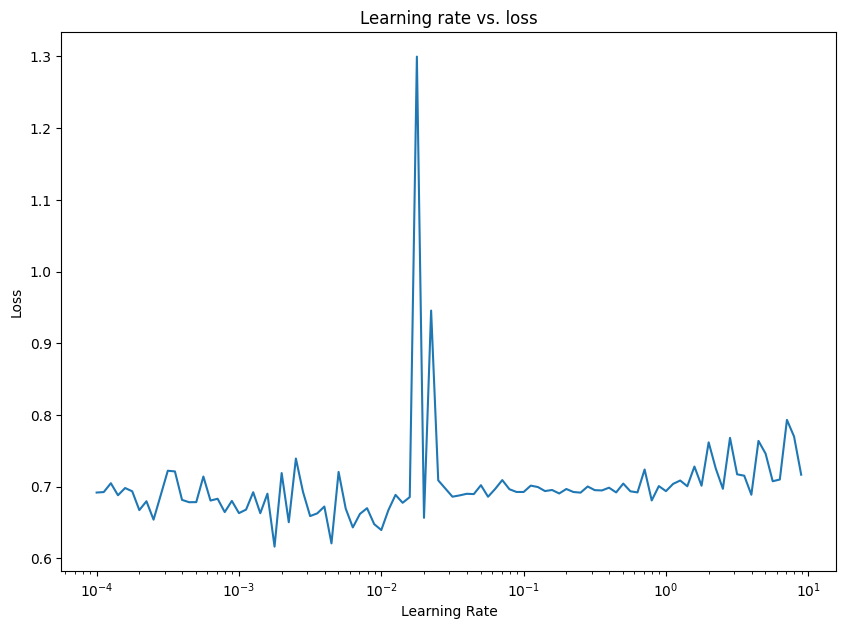

In [23]:
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, model_2_history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [24]:
lr = 1.9 * 10 ** -3
lr

0.0019

In [25]:
tf.random.set_seed(42)
model_3 = tf.keras.models.clone_model(model_1)
model_3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=["accuracy"]
)
model_3_history = model_3.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    batch_size=BATCHSIZE,
    validation_data=test_data,
    validation_steps=len(test_data),
    verbose=1,
)

model_3.evaluate(test_data, batch_size=BATCHSIZE)

Epoch 1/10
25/25 [==============================] - 12s 454ms/step - loss: 0.6939 - accuracy: 0.4963 - val_loss: 0.6907 - val_accuracy: 0.5050
Epoch 2/10
25/25 [==============================] - 11s 446ms/step - loss: 0.6899 - accuracy: 0.5325 - val_loss: 0.6847 - val_accuracy: 0.5550
Epoch 3/10
25/25 [==============================] - 11s 446ms/step - loss: 0.6594 - accuracy: 0.5987 - val_loss: 0.6215 - val_accuracy: 0.6400
Epoch 4/10
25/25 [==============================] - 11s 445ms/step - loss: 0.5770 - accuracy: 0.7237 - val_loss: 0.5275 - val_accuracy: 0.7150
Epoch 5/10
25/25 [==============================] - 11s 451ms/step - loss: 0.4860 - accuracy: 0.7738 - val_loss: 0.4403 - val_accuracy: 0.8200
Epoch 6/10
25/25 [==============================] - 11s 446ms/step - loss: 0.4942 - accuracy: 0.7613 - val_loss: 0.4134 - val_accuracy: 0.8350
Epoch 7/10
25/25 [==============================] - 11s 448ms/step - loss: 0.4383 - accuracy: 0.8138 - val_loss: 0.3967 - val_accuracy: 0.8150

[0.31956470012664795, 0.8450000286102295]

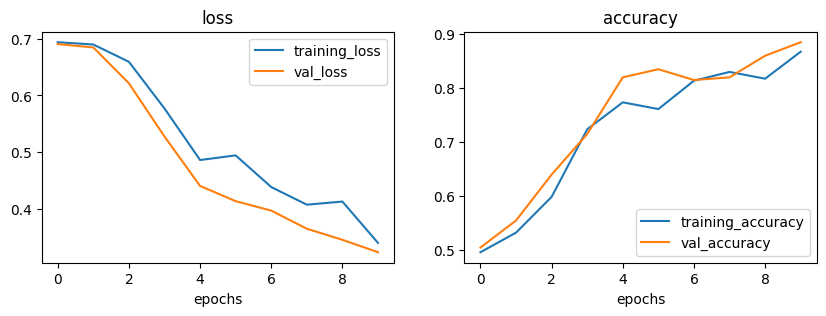

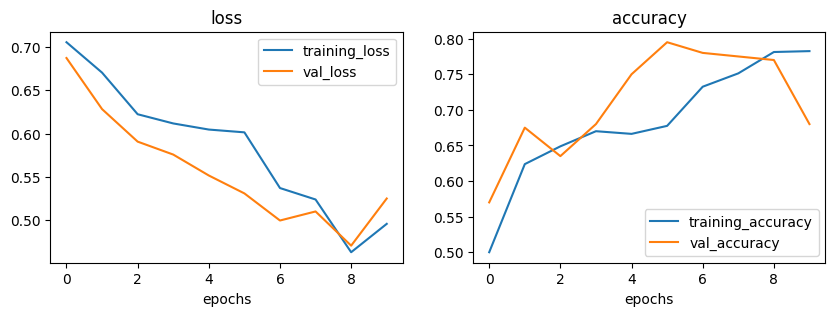

In [26]:
plot_loss_curves(model_3_history)
plot_loss_curves(model_1_history)